In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00


In [ ]:
!pip install wandb

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoConfig, DebertaV2Config, DebertaV2ForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
import os
import gc
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wandb login
#31c3e3f7ed9f3d17977e89a80ca5f4af872642ef

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sandraru (sandraru-victoria-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
wandb.init(project="CHIPP-AI-model65")

wandb: Currently logged in as: sandraru (sandraru-victoria-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
model_name = 'microsoft/deberta-v3-base'

# Loading the dataset

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/train_65_10_25.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Datasets/val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/test.csv')

In [ ]:
train_df.isna().sum()

,0
review,0
sentiment,0


In [ ]:
train_df.value_counts('sentiment')

,count
sentiment,
2,1365000
0,525000
1,210000


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
type(tokenizer)

transformers.models.deberta_v2.tokenization_deberta_v2_fast.DebertaV2TokenizerFast

In [ ]:
# Calculating the tokenized sequence lengths in the training dataset
# Determining an optimal max_length
tokenized_lengths = [
    {'review': review, 'length': len(tokenizer(review)['input_ids'])}
    for review in train_dataset['review']
]

In [ ]:
all_lengths = [review['length'] for review in tokenized_lengths]
print(f"95th percentile of sequence lengths: {int(np.percentile(all_lengths, 95))}")
print(f"98th percentile of sequence lengths: {int(np.percentile(all_lengths, 98))}")
print(f"99th percentile of sequence lengths: {int(np.percentile(all_lengths, 99))}")
print(f"99.5th percentile of sequence lengths: {int(np.percentile(all_lengths, 99.5))}")

longest_review = max(tokenized_lengths, key=lambda x: x['length'])
print(f"Longest sequence length: {longest_review['length']}")
print(f"Review with the longest sequence: {longest_review['review']}")

95th percentile of sequence lengths: 160
98th percentile of sequence lengths: 246
99th percentile of sequence lengths: 333
99.5th percentile of sequence lengths: 441
Longest sequence length: 7238
Review with the longest sequence: Beware: You can't buy more glasses...  But it will work on a Mac. UPDATE: I changed my review from 3 stars to 1 because after 1.5 years of fairly light usage, this monitor no longer functions.  Now when it is turned on, it's own built-in logo and 'check cable' displays roll and flicker.  Connecting a computer (any input) and displaying an image results in the same problem.  At some point I'll take this apart and see if I can fix it but don't hold out much hope.  Perhaps if I used it more it would have failed during the 1 year warranty.<br /><br />This is a very long review, so let me bring an import issue up front.  This monitor comes with 1 pair of glasses and 1 pair of clip-ons, and as of the date of this review (early Fall 2011) you cannot buy more of these

In [ ]:
def tokenize(example):
  return tokenizer(example['review'], truncation=True, padding="max_length", max_length=256)

In [ ]:
tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_val = val_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/2100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/450000 [00:00<?, ? examples/s]

Map:   0%|          | 0/450000 [00:00<?, ? examples/s]

In [ ]:
tokenized_train = tokenized_train.rename_column("sentiment", "labels")
tokenized_val = tokenized_val.rename_column("sentiment", "labels")
tokenized_test = tokenized_test.rename_column("sentiment", "labels")

In [ ]:
# Viewing the default configuration
config = AutoConfig.from_pretrained(model_name)
print(config)

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.48.3",
  "type_vocab_size": 0,
  "vocab_size": 128100
}



In [ ]:
model = DebertaV2ForSequenceClassification.from_pretrained(model_name, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1, num_labels=3)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Passing the model to GPU

In [ ]:
!nvidia-smi

Mon Feb 17 21:25:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
os.environ.get('CUDA_VISIBLE_DEVICES')
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu124
12.4


In [ ]:
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

CUDA available: True
CUDA device count: 1
Current CUDA device: 0


In [ ]:
def clear_gpu_memory():
    '''
    Free GPU memory
    '''
    # Trigger Python garbage collection
    gc.collect()
    # Clear PyTorch's CUDA cache
    torch.cuda.empty_cache()

clear_gpu_memory()

# Training Model

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc,
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=256,
    learning_rate= 2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    label_smoothing_factor=0.1,
    lr_scheduler_type='cosine',
    adam_beta1=0.9,
    adam_beta2=0.98,
    warmup_ratio=0.1,
    run_name="model65_finetuning",
    report_to='wandb',
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)] # Stop after 2 consecutive epochs without improvement
)

In [ ]:
# Training the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.474500,0.418758,0.927549,0.921492,0.919834,0.927549,0.805438


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.474500,0.418758,0.927549,0.921492,0.919834,0.927549,0.805438
2,0.464300,0.418028,0.928516,0.921876,0.921609,0.928516,0.809741
3,0.462800,0.418183,0.928791,0.924095,0.922364,0.928791,0.810280


TrainOutput(global_step=49221, training_loss=0.4769329642831004, metrics={'train_runtime': 25487.4358, 'train_samples_per_second': 329.574, 'train_steps_per_second': 2.575, 'total_flos': 8.28822129408e+17, 'train_loss': 0.4769329642831004, 'epoch': 3.0})

In [ ]:
# Evaluating the model
results = trainer.evaluate(eval_dataset=tokenized_test)
print(results)

{'eval_loss': 0.41716432571411133, 'eval_accuracy': 0.9284644444444444, 'eval_f1': 0.9217655884874845, 'eval_precision': 0.9214808420332447, 'eval_recall': 0.9284644444444444, 'eval_mcc': 0.8098346383649502, 'eval_runtime': 690.9323, 'eval_samples_per_second': 651.294, 'eval_steps_per_second': 2.544, 'epoch': 3.0}


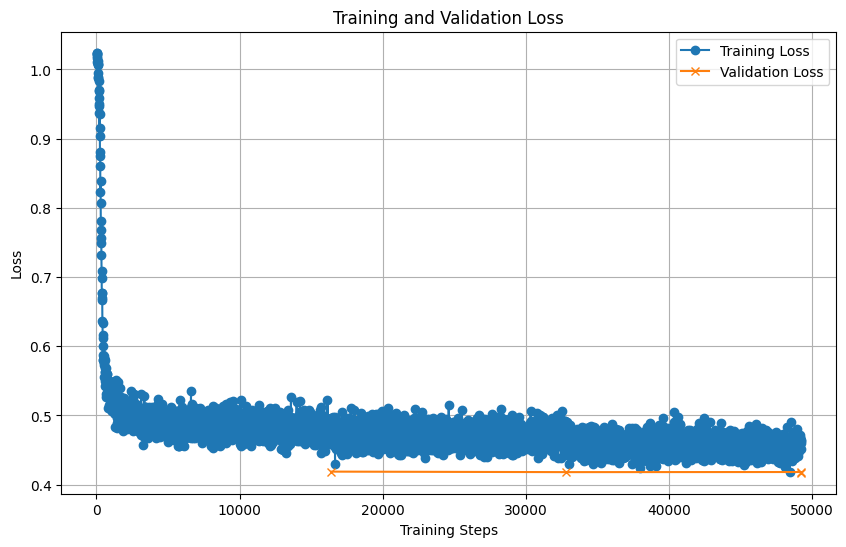

In [ ]:
# Extract log history from the trainer
logs = trainer.state.log_history

# Separate training and validation losses
train_losses = [entry["loss"] for entry in logs if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
steps = [entry["step"] for entry in logs if "loss" in entry]  # Steps corresponding to training losses
eval_steps = [entry["step"] for entry in logs if "eval_loss" in entry]  # Steps for eval losses

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label="Training Loss", marker="o")
plt.plot(eval_steps, eval_losses, label="Validation Loss", marker="x")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

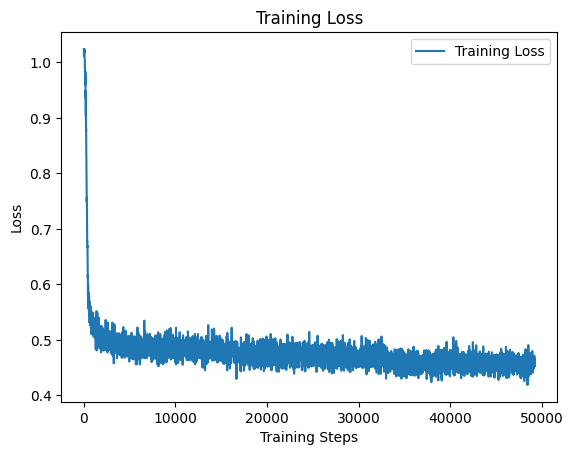

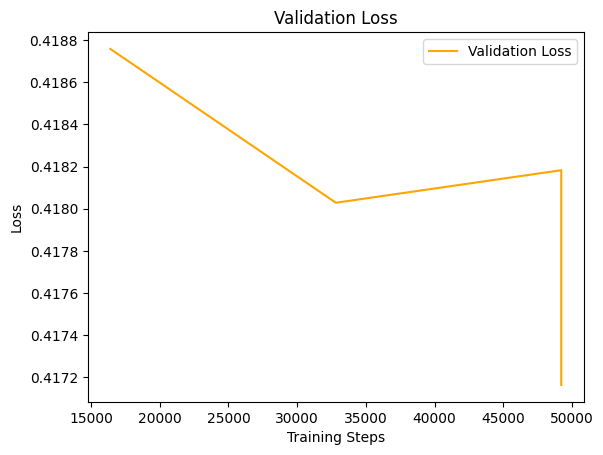

In [ ]:
# Convert logs to DataFrame
df = pd.DataFrame(logs)

# Filter for loss
df_loss = df[df['loss'].notna()]

# Plot training loss
plt.plot(df_loss['step'], df_loss['loss'], label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot validation loss
df_eval = df[df['eval_loss'].notna()]
plt.plot(df_eval['step'], df_eval['eval_loss'], label='Validation Loss', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

# Saving the model

In [ ]:
save_directory = '/content/drive/MyDrive/DeBERTa-65-10-25'
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/DeBERTa-65-10-25/tokenizer_config.json',
 '/content/drive/MyDrive/DeBERTa-65-10-25/special_tokens_map.json',
 '/content/drive/MyDrive/DeBERTa-65-10-25/spm.model',
 '/content/drive/MyDrive/DeBERTa-65-10-25/added_tokens.json',
 '/content/drive/MyDrive/DeBERTa-65-10-25/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and your fine-tuned model
model_name_or_path = "/content/drive/MyDrive/DeBERTa-65-10-25"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)

# Set the model to evaluation mode
model.eval()

In [ ]:
# Define your input text
text = "Battery life is good, but speed was extremely slow though."

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt")

# Run inference (ensure no gradients are computed)
with torch.no_grad():
    outputs = model(**inputs)

# For classification: get the logits and determine the predicted class
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=-1).item()

print("Predicted class ID:", predicted_class_id)

Predicted class ID: 1
